In [25]:
import numpy as np
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
from numpy import genfromtxt

%matplotlib inline

In [26]:
labels = ["", "", "", "", "", "", "", "", "", "", "A", "B", "C", "D", "", "", "E", "F", "G", "H", "I", "J", 
          "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "c", "d", "e", "f", 
          "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
exclude = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15]

train_data_src = ["train-data01.jpg", "train-data02.jpg", "train-data03.jpg", "train-data04.jpg", "train-data05.jpg",
                  "train-data06.jpg", "train-data07.jpg", "train-data08.jpg"]
# train_data_src = ["train-data01.jpg", "train-data02.jpg"]
test_data_src = "train-data09.jpg"

image_data = []
for tds in train_data_src:
    img = Image.open(tds)
    dataset = []
    i = 0
    for l in labels:
        x, y = (151 + (200 * (i % 8))), (268 + (260 * int(i / 8)))
        w, h = 199, 199
        img2 = img.crop((x, y, x+w, y+h))
        if i in exclude:
            img2 = np.zeros([w, h])
        dataset.append((img2, l))
        i += 1
    image_data.append(dataset)

test_data = []
img = Image.open(test_data_src)
i = 0
for l in labels:       
    x, y = (151 + (200 * (i % 8))), (268 + (260 * int(i / 8)))
    w, h = 199, 199
    img2 = img.crop((x, y, x+w, y+h))
    if i in exclude:
        img2 = np.zeros([w, h])
    test_data.append(asarray(img2))
    i += 1

label, img = image_data[1][10]
print(label)
img

<PIL.Image.Image image mode=L size=199x199 at 0x15927B81930>


'A'

In [27]:
threshhold = 50

def first_nonzero(arr, axis, invalid_val=np.Infinity):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def last_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

def crop(img, x, y, w, h):
    return img[y:y+h, x:x+w]

def prepare_data(data):
    for i in range(len(data)):
        _d = data[i]
        if isinstance(_d, tuple): dp, label = _d
        else: dp = _d

        dp = np.copy(asarray(dp))
        dp[dp <= threshhold] = 1
        dp[dp > threshhold] = 0
        dp = np.pad(dp, (0, 1), mode="constant")

        x = int(np.min(first_nonzero(dp, axis=1)))
        y = int(np.min(first_nonzero(dp, axis=0)))
        w = int(np.max(last_nonzero(dp, axis=1))) - x
        h = int(np.max(last_nonzero(dp, axis=0))) - y
        # print(x, y, w, h)
        cropped = crop(dp, x, y, w, h)
        pad_x = int(100 - (w / 2))
        pad_y = int(100 - (h / 2))
        pad_x2 = pad_x + (1 if (w % 2 != 0) else 0)
        pad_y2 = pad_y + (1 if (h % 2 != 0) else 0)
        dp = np.pad(cropped, [(pad_y, pad_y2), (pad_x, pad_x2)], mode="constant")

        if isinstance(_d, tuple): data[i] = (dp, label)
        else: data[i] = dp
    return data

image_data = list(map(prepare_data, image_data))
test_data = prepare_data(test_data)

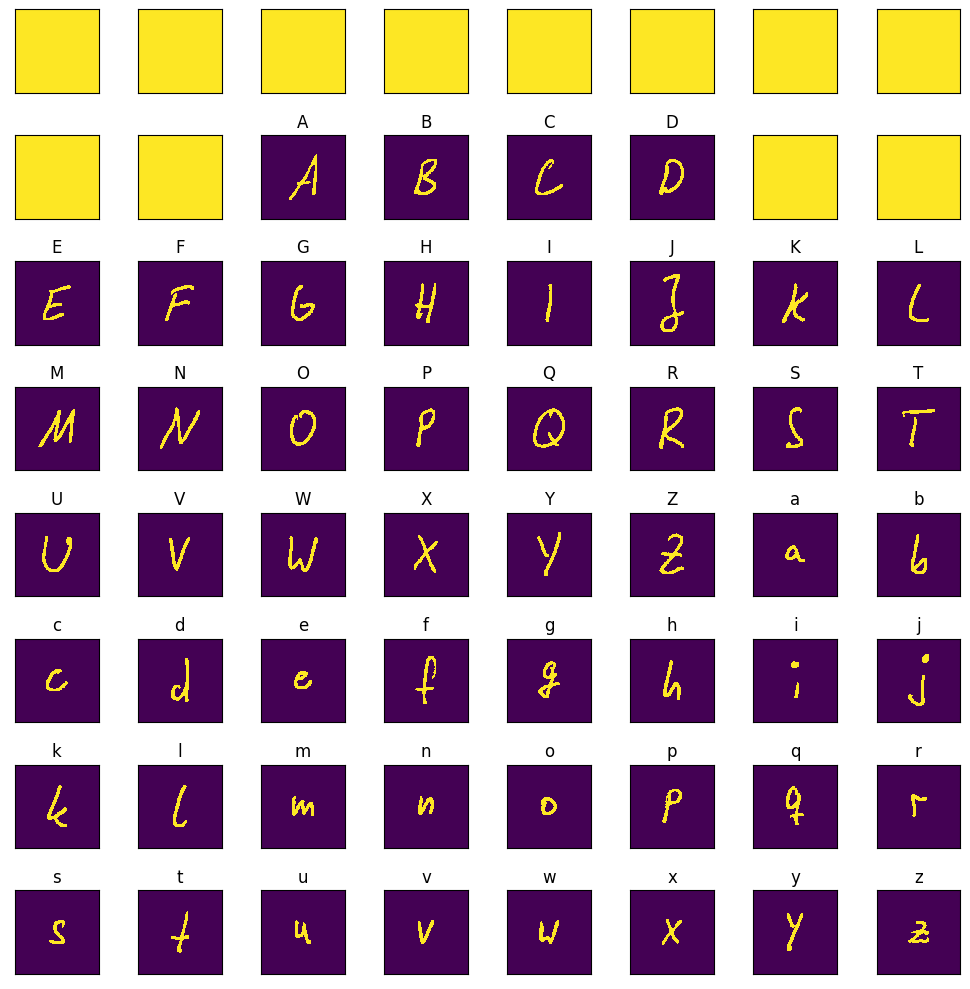

In [28]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
plot_data = image_data[1]
for ax, (x, l) in zip(axs.flat, plot_data):
    ax.imshow(x, interpolation='nearest')
    ax.set_title(l)

plt.tight_layout()
plt.show()

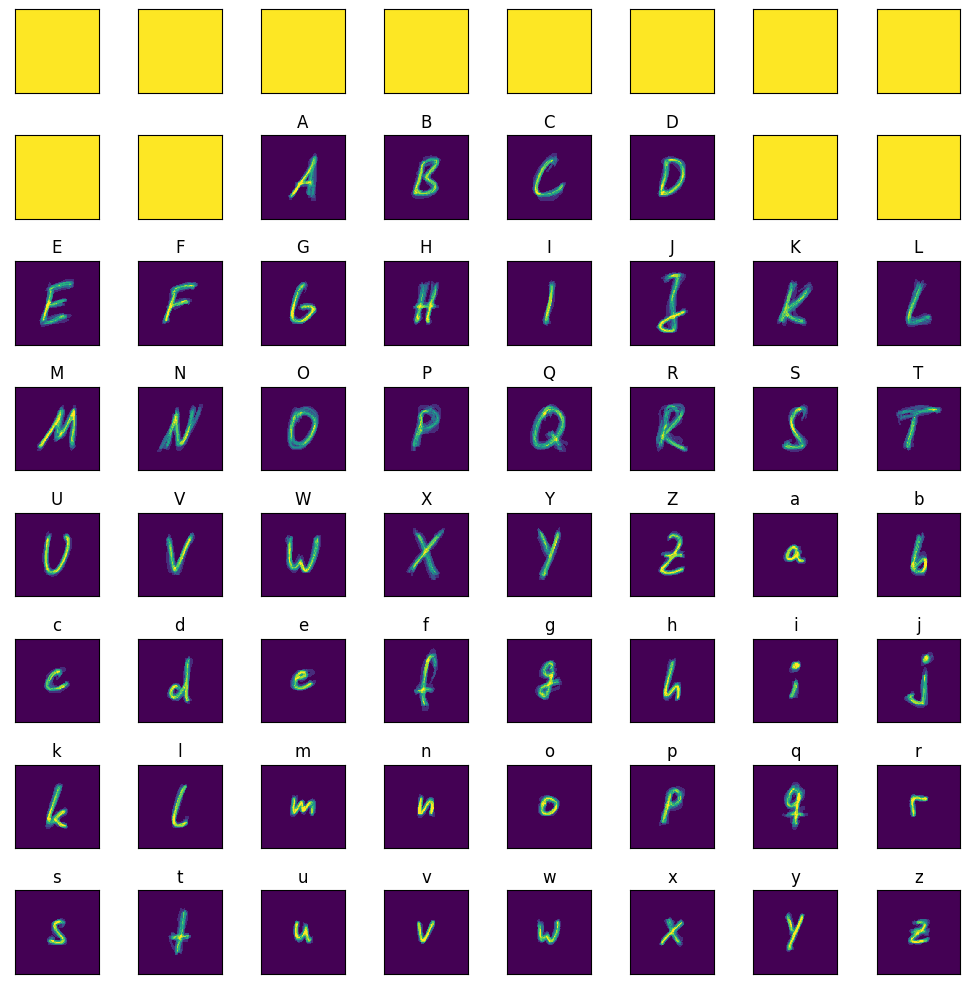

In [29]:
def img_avg(imgs):
    M, _ = imgs[0][0]
    h, w = M.shape
    result = []
    lIndex = 0
    for l in labels:
        avg_matrix = np.zeros([h, w]).astype(float)
        for y in range(h):
            for x in range(w):
                sum = 0
                for i in range(len(imgs)):
                    value, _ = imgs[i][lIndex]
                    sum += value[y][x]
                avg_matrix[y][x] = float(sum) / float(len(imgs))
        result.append((avg_matrix, l))
        lIndex += 1
    return result

avg = img_avg(image_data)
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for ax, (x, l) in zip(axs.flat, avg):
    ax.imshow(x, interpolation='nearest')
    ax.set_title(l)

plt.tight_layout()
plt.show()

In [30]:
def eukl_dist_old(img_i, img_j):
    i = img_i.reshape(-1)
    j = img_j.reshape(-1)
    result = np.zeros([len(i)]).astype(float)
    for x in range(len(i)):
        result[x] = (i[x] - j[x])**2
    return np.sqrt(result.sum())

def eukl_dist(img_i, img_j):
    i = img_i.reshape(-1)
    j = img_j.reshape(-1)
    return np.linalg.norm(i-j)

def manh_dist(img_i, img_j):
    i = img_i.reshape(-1)
    j = img_j.reshape(-1)
    result = np.zeros([len(i)]).astype(float)
    for x in range(len(i)):
        result[x] = abs(i[x] - j[x])
    return result.sum()

def get_dists_to_datapoints(dp1, dp2):
    v1, l1 = dp1
    v2, l2 = dp2
    if (l1 != l2):
        raise Exception("labels not equal")
    dist = eukl_dist(v1, v2)
    return (dist, l1)

def get_dist_for_letter(img_letter_array):
    result = []
    for y in range(len(img_letter_array)):
        row = []
        for x in range((y+1), len(img_letter_array)):
            dp1 = img_letter_array[x]
            dp2 = img_letter_array[y]
            row.append(get_dists_to_datapoints(dp1, dp2))
        result.append(row)
    return result

def get_dist_from_matrix(m):
    _, label = m[0][0]
    values = []
    for j in range(len(m)):
        for i in range(len(m[j])):
            v, l = m[j][i]
            values.append(v)
    return (np.array(values).mean(), label)

def get_dists_for_train_data(train_data):
    dists = []
    for j in range(len(train_data[0])):
        letter_array = []
        for i in range(len(train_data)):
            letter_array.append(train_data[i][j])
        letter_matrix = get_dist_for_letter(letter_array)
        dists.append(get_dist_from_matrix(letter_matrix))
    return dists

[(0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (0.0, ''), (6503.317677511333, 'A'), (7396.071469783844, 'B'), (6667.238269707852, 'C'), (6933.137123024652, 'D'), (0.0, ''), (0.0, ''), (7414.918564556848, 'E'), (6036.943189348779, 'F'), (6064.4938250834075, 'G'), (7116.736198948769, 'H'), (4424.567373241608, 'I'), (8056.08130040954, 'J'), (7696.285806064712, 'K'), (6541.405011377737, 'L'), (7472.951276413429, 'M'), (8000.8648732379, 'N'), (7945.718709235226, 'O'), (7487.819438938166, 'P'), (8961.621486242393, 'Q'), (8610.347732257234, 'R'), (6510.669939555887, 'S'), (7387.73094009333, 'T'), (6228.067572178766, 'U'), (6167.059425030203, 'V'), (6999.934293057289, 'W'), (7464.689153633897, 'X'), (6263.799434041654, 'Y'), (6252.346692280272, 'Z'), (3996.8035360430395, 'a'), (6002.273451853963, 'b'), (4729.046270331432, 'c'), (6287.947820647391, 'd'), (4792.506974420115, 'e'), (6486.023338867753, 'f'), (6733.976550578952, 'g'), (5671.14434

<BarContainer object of 64 artists>

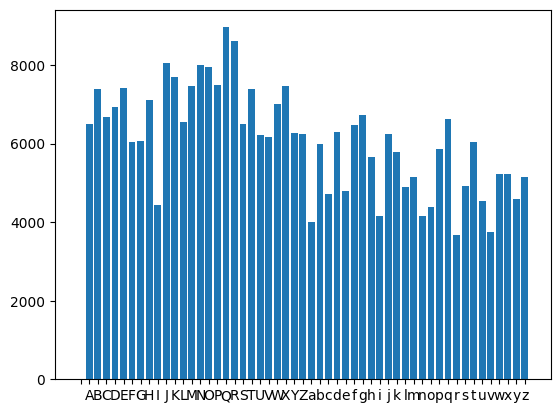

In [31]:
train_dist_out = get_dists_for_train_data(image_data)
print(train_dist_out)

dist_values, dist_labels = [], []
for x in train_dist_out:
    value, label = x
    dist_values.append(value)
    dist_labels.append(label)
plt.bar(dist_labels, dist_values)

<BarContainer object of 64 artists>

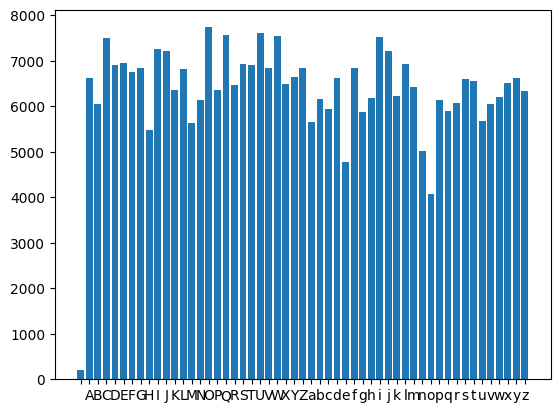

In [32]:
def get_dist_to_train(train_data, test_img):
    dist_to_train = []
    for j in range(len(train_data[0])):
        _, label = train_data[0][j]
        letter_array = []
        for i in range(len(train_data)):
            v, l = train_data[i][j]
            letter_array.append(eukl_dist(v, test_img))
        dist_to_train.append((np.mean(letter_array), label))
    return dist_to_train

A = test_data[10]
u = test_data[58]
H = test_data[19]
a = test_data[38]
l = test_data[49]
o = test_data[52]

test_dist_out = get_dist_to_train(image_data, o)

dist_values, dist_labels = [], []
for v, l in test_dist_out:
    dist_values.append(v)
    dist_labels.append(l)
plt.bar(dist_labels, dist_values)

<BarContainer object of 64 artists>

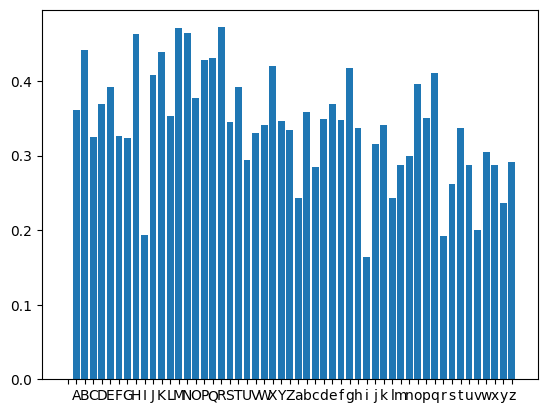

In [33]:
def exp_func(d, u):
    return np.exp(-d / (u + 0.0000001))

def apply_exp_to_test(train_dist, test_dist):
    result = []
    for i in range(len(test_dist)):
        v_train, label = train_dist[i]
        v_test, _ = test_dist[i]
        result.append((exp_func(v_test, v_train), label))
    return result

exp_out = apply_exp_to_test(train_dist_out, test_dist_out)

dist_values, dist_labels = [], []
for v, l in exp_out:
    dist_values.append(v)
    dist_labels.append(l)
plt.bar(dist_labels, dist_values)

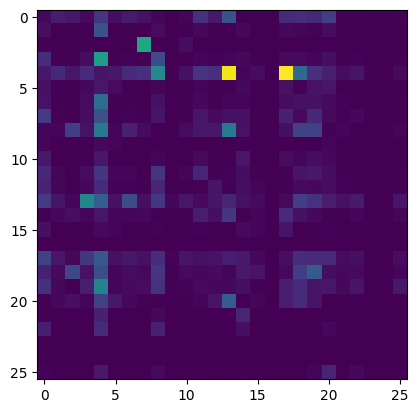

In [34]:
character_labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
character_transition_data = genfromtxt('character_transitions.csv', delimiter=',')
character_transition_data = character_transition_data / 10000

plt.imshow(character_transition_data, interpolation='nearest')

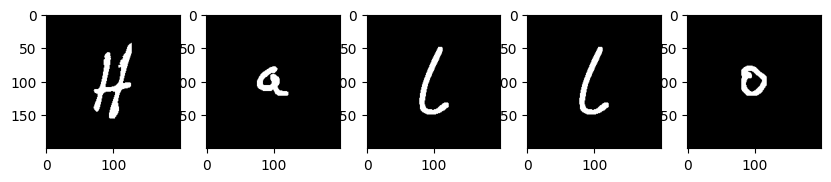

In [35]:
H = test_data[19]
a = test_data[38]
l = test_data[49]
o = test_data[52]

test_hallo = [H, a, l, l, o]

fig = plt.figure(figsize=(10, 2))
for i in range(5):  
    x = test_hallo[i]
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(x, cmap='gray')

In [36]:
firstLetter = (np.Infinity, "None")

dist_out = softmax_labels(get_dists_to_traindata(o))
for dp in dist_out:
    v1, l1 = dp
    v2, l2 = firstLetter
    if (v1 < v2):
        firstLetter = dp
    
firstLetter

dist_values, dist_labels = [], []
for x in dist_out:
    value, label = x
    dist_values.append(value)
    dist_labels.append(label)
plt.bar(dist_labels, dist_values)

plt.bar(dist_labels, dist_values)
np.sum(dist_values)

NameError: name 'softmax_labels' is not defined